In [31]:
import math 
from scipy.stats import norm
import scipy.optimize as opt
import numpy as np

tradeDaysPerYear = 252

# implement standard Black-Scholes functions

def nPrime(x):
    d = math.exp(-x ** 2 / 2) / math.sqrt(2 * math.pi)
    return d
    
def bsGamma(vol, t, T, r, S_t, K):
    if(t >= T):
        return 0
    d_1 = d1(vol, t, T, r, S_t, K)
    n = nPrime(d_1)
    return n / (S * vol * math.sqrt(T - t))

def d1(vol, t, T, r, S_t, K):
    f1 = 1 / (vol * math.sqrt(T - t))
    f2 = math.log(S_t / K) + (r + (vol * vol) / 2)  * (T-t)
    return f1 * f2

def d2(vol, t, T, r, S_t, K):
    return d1(vol, t, T, r, S_t, K) - vol * math.sqrt(T - t)

def PV(t, T, r, K):
    return K * math.exp(-r * (T - t))

def bsCallPrice(vol, t, T, r, S_t, K):
    if(t >= T):
        return max(0, S_t - K)
    d_1 = d1(vol, t, T, r, S_t, K)
    d_2 = d2(vol, t, T, r, S_t, K)
    price = norm.cdf(d_1) * S_t - norm.cdf(d_2) * PV(t, T, r, K)
    return price

def bsCallDelta(vol, t, T, r, S_t, K):
    if t >= T:
        return max(0, K - S_t)
    d = norm.cdf(d1(vol, t, T, r, S_t, K))
    return d
    
def putDelta(vol, t, T, r, S_t, K):
    d = 1 - norm.cdf(d1(vol, t, T, r, S_t, K))
    return d

def bsPutPrice(vol, t, T, r, S_t, K):
    if(t >= T):
        return 0
    d_1 = d1(vol, t, T, r, S_t, K)
    d_2 = d2(vol, t, T, r, S_t, K)
    price = norm.cdf(-d_2) * PV(t, T, r, K) - norm.cdf(-d_1) * S_t
    price = PV(t, T, r, K) - S_t + bsCallPrice(vol, t, T, r, S_t, K)
    return price

def bsCallImpVol(vol, *args):
    price, t, T, r, S_t, K = args
    return bsCallPrice(vol, t, T, r, S_t, K) - price

def bsPutImpVol(vol, *args):
    price, t, T, r, S_t, K = args
    return bsPutPrice(vol, t, T, r, S_t, K) - price
    
def bsCallSpreadCost(k1, k2, vol1, vol2, t, T, r, S_t):
    p = bsPutPrice(vol1, t, T, r, S_t, k1)
    c = bsCallPrice(vol2, t, T, r, S_t, k2)
    spreadPrice = p - c
    return spreadPrice

# implement 'hedged call' class, that simulates delta hedging a long call option

class bsHedgedCall:
    
    def __init__(self, impVol, t, T, r, S_t, K, realizedVol, hedgedVol, transactionCost):
        self.vol = impVol
        self.startSpot = 0
        self.realizedVol = realizedVol
        self.hedgedVol = hedgedVol
        self.transactionCost = transactionCost
        self.t = t
        self.T = T
        self.r = r
        self.S_t = S_t
        self.K = K
        self.timeStep = 0
        self.callPrice = bsCallPrice(impVol, t, T, r, S_t, K)
        self.delta = bsCallDelta(self.hedgedVol, self.t, self.T, self.r, self.S_t, self.K)
        self.sharesHeld = - self.delta
        self.cash = - (self.callPrice + self.sharesHeld * self.S_t) #cash position = liabilities - assets = - assets
        self.priceSeries = [S_t]
        self.gainLoss = 0
        self.cumulativeGainLoss = [self.gainLoss]
        self.move = 0
        
    def nextStep(self, step):
        prevSpot = self.S_t
        prevCallPrice = self.callPrice
        self.move = self.realizedVol * np.random.normal(0,1) * math.sqrt(step) * self.S_t        
        self.S_t = self.S_t + self.move
        self.t = self.t + step
        self.callPrice = bsCallPrice(self.vol, self.t, self.T, self.r, self.S_t, self.K)
        callPriceChange = self.callPrice - prevCallPrice
        hedgeInstrumentPriceChange = (self.S_t - prevSpot) * self.sharesHeld  
        interestOnCash = (self.cash * math.exp(r * step) - self.cash)        
        self.gainLoss = callPriceChange + hedgeInstrumentPriceChange + interestOnCash
        lastVal = self.cumulativeGainLoss[-1]
        self.delta = bsCallDelta(self.hedgedVol, self.t, self.T, self.r, self.S_t, self.K)
        prevSharesHeld = self.sharesHeld
        self.sharesHeld = - self.delta
        tc = abs(self.sharesHeld * self.S_t - prevSharesHeld * prevSpot) * self.transactionCost #tc's scale with traded notional
        if(abs(self.t - self.T) < step / 2): 
           tc = 0 #don't count the last unwind trade
        self.cumulativeGainLoss.append(lastVal + self.gainLoss - tc)        
        self.cash = - (self.callPrice + self.sharesHeld * self.S_t)
        self.priceSeries.append(self.S_t)

    def runHedge(self, hedgesPerDay):
        days = (self.T - self.t) * tradeDaysPerYear
        steps = round(days * hedgesPerDay)
        stepLen = (self.T - self.t) / steps
        for x in range(steps):
            self.nextStep(stepLen)
            
   

call price:  7.965567455405804


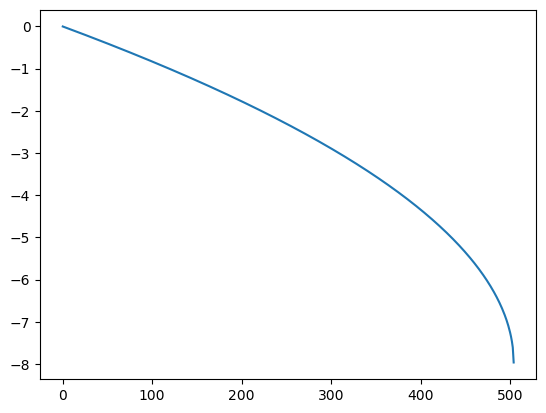

In [32]:
#resonableness check on the 'bsHedgedCall' function above 

#first plug in ~0 realized vol, where we expect to observe a 
#negative pnl, in fact a total loss of all the asset's value, since there is no
#offsetting positive carry (gamma gains) where all losses are purely due to the time
#decay of the option, with a shape consistent with the fact
#that time decays proportionally to sqrt(time to expiration)

S = 100 #spot price
impliedVol = .2
realizedVol = .0000001
r = 0.0 #risk-free interest rate   
K = 100 #option strike
t = 0 #t represents time in years, option expires at time T
hedgesPerDay = 2
numSimulations = 10
T = days / tradeDaysPerYear 
tcAssumption = 0.0


hedgedCall = bsHedgedCall(impliedVol,t,T,r,S,K,realizedVol,realizedVol, tcAssumption)
print('call price: ', hedgedCall.callPrice)
hedgedCall.runHedge(hedgesPerDay)
PnL = getattr(hedgedCall, 'cumulativeGainLoss')
py.plot(PnL)

In [33]:
#check implied vol functions work, by calculating bs call/put price and then backing 
#out vol with bsCallImpVol/bsPutImpVol
import scipy.optimize as opt
vol1 = .15
vol2 = .22
t0 = 0.0
t1 = 1.0
r = .01 
k = 100 
s = 102 

callPrice = bsCallPrice(vol1, t0, t1, r, s, k)
putPrice = bsPutPrice(vol2, t0, t1, r, s, k)
print('call price: ', callPrice)
print('put price: ', putPrice)

vol0 = .1 #initial guess
#recover implied vol from option prices
imp1 = opt.fsolve(bsCallImpVol, vol0, (callPrice, t0, t1, r, s, k))
imp2 = opt.fsolve(bsPutImpVol, vol0, (putPrice, t0, t1, r, s, k))

print('inputed vols: ', vol1, vol2)
print('vols backed out from option prices: ', imp1, imp2)
eps = .000000001 #correctness tolerance
calculationWorked = abs(vol1 - imp1) < eps and abs(vol2 - imp2) < eps
print('implied vols correctly backed out: ', calculationWorked)

call price:  7.6240531253517005
put price:  7.385885635213128
inputed vols:  0.15 0.22
vols backed out from option prices:  [0.15] [0.22]
implied vols correctly backed out:  [ True]


call cost:  10.450583572185565
hedges per day:  0.5
average PnL:  3.3640111872320873
standard deviation of PnL:  0.9258904569703417


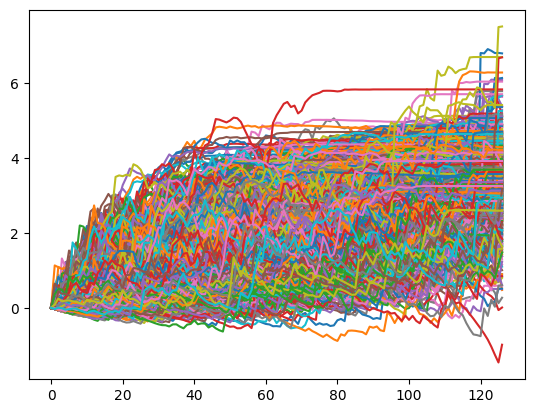

call cost:  10.450583572185565
hedges per day:  2.0
average PnL:  2.8382895475496195
standard deviation of PnL:  0.5354848560217491


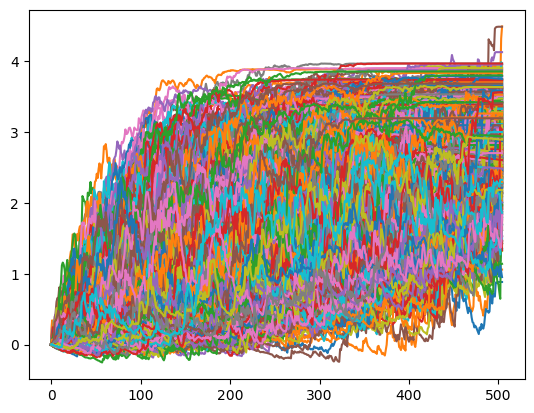

In [34]:
#next we illustrate a standard tradeoff when delta hedging, the tradeoff of choosing how
#frequently to hedge: more frequent hedging reduces PnL volatility but
#results in an increase in transaction costs and so a lower average PnL
#we observe that increasing the hedging frequency by 4x roughly halves
#the observed PnL standard deviation, which is expected since the standard devation
#of PnL roughly scales with 1 / sqrt(n), so increasing from n to 4n gives
#PnL standard deviation with 4n hedges = (PnL standard devation with n hedges) * 1 / sqrt(4) 
#                                      = (PnL standard devation with n hedges) * 1 / 2
#we also observe that the more frequenly hedged options have a lower average PnL,
#expected since we pay more in transaction costs

import matplotlib.pyplot as py
import statistics as stats

S = 100
impliedVol = .2
#we set the realized vol equal to 30%, so we expect to gain by buying the option at an implied
#vol of 20% and hedging it. this is what we observe
realizedVol = 1.5 * impliedVol
r = 0.05
K = 100
t = 0
hedgesPerDay = .5 #start by hedging every other day
halveStdDev = 4 #standard deviation of PnL roughly scales with 1 / sqrt(n), so increase n by 4x to halve the standard deviation
numSimulations = 1000
T = days / tradeDaysPerYear
tcAssumption = .001 #1 bp transaction cost assumption for trading underlyer

def runSimulations(num):
    pnl = []
    hedgedCall = bsHedgedCall(impliedVol,t,T,r,S,K,realizedVol,realizedVol, tcAssumption)    
    print('call cost: ', hedgedCall.callPrice)
    for x in range(num):
        hedgedCall = bsHedgedCall(impliedVol,t,T,r,S,K,realizedVol,realizedVol, tcAssumption)
        hedgedCall.runHedge(hedgesPerDay)
        PnL = getattr(hedgedCall, 'cumulativeGainLoss')
        pnl.append(PnL[-1])
        py.plot(PnL)
    print('hedges per day: ', hedgesPerDay)
    print('average PnL: ', stats.mean(pnl))
    print('standard deviation of PnL: ', stats.stdev(pnl))
    py.show()
    py.close()

#display the distibution of PnL starting with 1 hedge every 4 days
runSimulations(numSimulations)

#increase num simulations by factor of 4, halving the PnL volatility, as we informally observe
hedgesPerDay = hedgesPerDay * halveStdDev
runSimulations(numSimulations)

using implied vol as hedging vol:  True
hedges per day:  50
average PnL:  4.43056927068374
standard deviation of PnL:  2.036494174107421


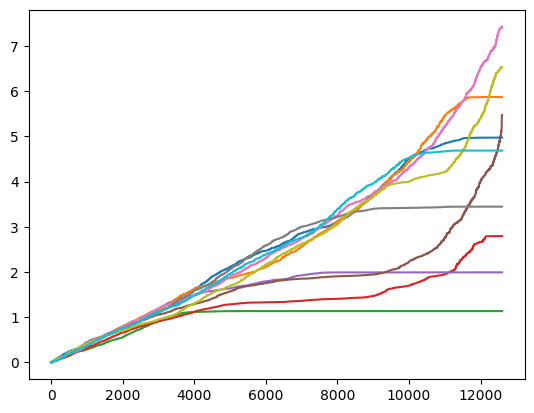

expected PnL when hedging with known realized vol:  3.780671213800261
using realized vol as hedging vol:  True
hedges per day:  50
average PnL:  3.8481036199643017
standard deviation of PnL:  0.13007445877432963


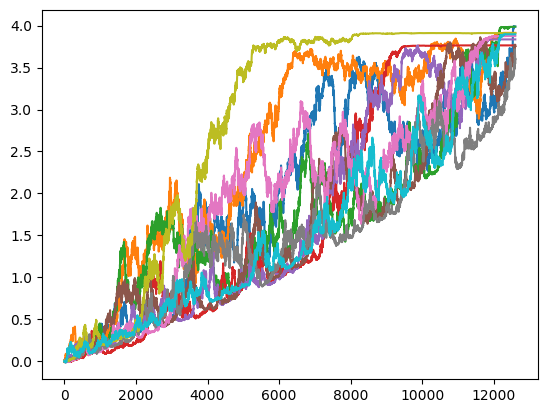

In [36]:
#next we illustrate the standard idea that hedging with known realized vol (not realistic,
#since future realize vol is unknown in practic) results in roughly deterministic final 
#PnL (equal to the call price with implied vol set to the known realized vol
#minus the call price with implied vol set the assumed implied vol).
#in contrast, hedging with implied vol results in path-dependent final PnL


import matplotlib.pyplot as py
import statistics as stats

S = 100
impliedVol = .2
realizedVol = 1.5 * impliedVol
r = 0.05
K = 100
t = 0
days = 252
hedgesPerDay = 50
numSimulations = 10
T = days / 252
tcAssumption = 0.0 

def runSimulations(num, hedgeWithImpliedVol):
    pnl = [] #list of final PnL's from a range of simulations
    for x in range(num):
        hedgingVol = impliedVol if hedgeWithImpliedVol else realizedVol
        hedgedCall = bsHedgedCall(impliedVol,t,T,r,S,K,realizedVol, hedgingVol, tcAssumption)
        hedgedCall.runHedge(hedgesPerDay)
        PnL = getattr(hedgedCall, 'cumulativeGainLoss')
        pnl.append(PnL[-1])
        py.plot(PnL)
    print('hedges per day: ', hedgesPerDay)
    print('average PnL: ', stats.mean(pnl))
    print('standard deviation of PnL: ', stats.stdev(pnl))
    py.show()
    py.close()

useImplied = True
print('using implied vol as hedging vol: ', useImplied)
runSimulations(numSimulations, useImplied)
useImplied = False
expectedPnL = bsCallPrice(realizedVol, t, T, r, S, K) - bsCallPrice(impliedVol, t, T, r, S, K)
print('expected PnL when hedging with known realized vol: ', expectedPnL)
print('using realized vol as hedging vol: ', not useImplied)
runSimulations(numSimulations, useImplied)
